In [1]:
import time

import rospy
import pcl_ros
from sensor_msgs.msg import PointCloud2
import sensor_msgs.point_cloud2 as pc2
import ros_numpy
import numpy as np

import tf
import geometry_msgs.msg

In [2]:
rospy.init_node('listener', anonymous=True)

In [3]:
points_list = []

time.sleep(10)
tfListener = tf.TransformListener()
tfROS = tf.TransformerROS()

def callback(data):
    pc=ros_numpy.numpify(data)
    pc=ros_numpy.point_cloud2.split_rgb_field(pc)
    points=np.zeros((pc.shape[0],3))
    points[:,0]=pc['x']
    points[:,1]=pc['y']
    points[:,2]=pc['z']
    rgb=np.zeros((pc.shape[0],3))
    rgb[:,0]=pc['r']
    rgb[:,1]=pc['g']
    rgb[:,2]=pc['b']
    
    if len(points_list) < 10:
        t = tfListener.lookupTransform("world", "camera_depth_optical_frame", rospy.Time(0))
        T = tfROS.fromTranslationRotation(t[0],t[1])
        
        points_list.append((points,rgb,T))
        #points_list.append((points,rgb))

In [4]:
rospy.Subscriber("/camera/depth/color/points", PointCloud2, callback)
time.sleep(3)
len(points_list)

[ERROR] [1645971939.592902]: bad callback: <function callback at 0x7fcca6bfbd30>
Traceback (most recent call last):
  File "/opt/ros/noetic/lib/python3/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "<ipython-input-3-b44cc28ec071>", line 20, in callback
    t = tfListener.lookupTransform("world", "camera_depth_optical_frame", rospy.Time(0))
  File "/opt/ros/noetic/lib/python3/dist-packages/tf/listener.py", line 104, in lookupTransform
    msg = self._buffer.lookup_transform(strip_leading_slash(target_frame), strip_leading_slash(source_frame), time)
  File "/opt/ros/noetic/lib/python3/dist-packages/tf2_ros/buffer.py", line 86, in lookup_transform
    return self.lookup_transform_core(target_frame, source_frame, time)
tf2.LookupException: "camera_depth_optical_frame" passed to lookupTransform argument source_frame does not exist. 



5

In [5]:
points, rgb, T = points_list[0]

In [6]:
points = np.einsum('ij,bj->bi',T,np.concatenate((points,np.ones((points.shape[0],1))),axis=-1))[:,:3]

In [7]:
maxs = np.max(points,axis=0)
mins = np.min(points,axis=0)

L = (maxs - mins)
print(L)
print(mins)

[3.31863007 3.2743597  0.9686853 ]
[-0.43596533 -1.4796112  -0.71395746]


In [8]:
X = 4
Y = 4
pix = 1000

points_norm = (points + np.array([[0.6,1.7,0.]]))

In [9]:
points_x = points_norm[:,0]
points_y = points_norm[:,1]
points_z = points_norm[:,2]
r = rgb[:,0]
g = rgb[:,1]
b = rgb[:,2]

In [10]:
xy_sorted = np.stack((points_x[np.argsort(points_z)], points_y[np.argsort(points_z)]),axis=-1)
rgb_sorted = np.stack((r[np.argsort(points_z)], g[np.argsort(points_z)], b[np.argsort(points_z)]),axis=-1)

In [11]:
xy_sorted = np.floor(xy_sorted * pix).astype(int)

In [12]:
image = np.zeros((int(X*pix),int(Y*pix),3),int)

In [13]:
image.shape

(4000, 4000, 3)

In [14]:
image[2459,1361]

array([0, 0, 0])

In [15]:
for i,(x,y) in enumerate(xy_sorted):
    image[x,y] = rgb_sorted[i]

In [16]:
import matplotlib.pyplot as plt

In [17]:
image_cut = image[0:1000,500:2000].astype(np.uint8)

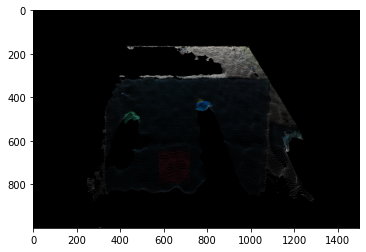

In [18]:
plt.imshow(image_cut)

In [19]:
from PIL import Image, ImageEnhance

In [20]:
img = Image.fromarray(image_cut)

In [21]:
factor = 0.3
img = img.resize((int(image_cut.shape[1]*factor), int(image_cut.shape[0]*factor)))

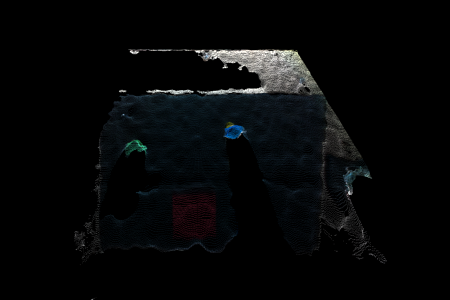

In [24]:
enhancer = ImageEnhance.Contrast(img)
result = enhancer.enhance(1.5)
result

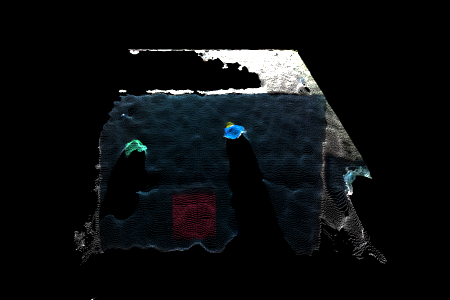

In [26]:
enhancer = ImageEnhance.Brightness(result)
enhancer.enhance(2.)